In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import scipy.sparse as sp
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib

%matplotlib inline

In [2]:
INPUT_CSV = "combined_pairs.csv"
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [5]:
df = pd.read_csv(INPUT_CSV)
print(f"Datos cargados: {len(df)} pares")

Datos cargados: 1371 pares


In [8]:
# Lista con todos los códigos del csv 
corpus = df['code1'].tolist() + df['code2'].tolist() 

# Configurar el vectorizador que se comporte de la sigueinte forma:
# Ingnorar identificadores de Java para no tomarlos ne cunta -> ',",),(,{,},[,],,,.,;,:,!?,+,-,*,/,%,**,//,==,!=,<,>,<=,>=,&&,||,=,+=,-=,\n,\t,\r,@,#,$,,/,~
# Mantener mayúsculas/minúsculas (importante en Java)
token_pattern = r"(?u)\b\w+\b|==|!=|<=|>=|&&|\|\||\+|-|\*|/|%|;|:|,|\.|\(|\)|\{|\}|\[|\]"
vectorizer = TfidfVectorizer(token_pattern=token_pattern, lowercase=False)


# Analiza el corpus y crea un diccionario con todas las palabras únicas
vectorizer.fit(corpus)
joblib.dump(vectorizer, "vectorizer.pkl")
print("Tamaño del diccionario:", len(vectorizer.vocabulary_))
print("Palabras en el diccionario:", list(vectorizer.vocabulary_.keys()))

# Convierte cada fragmento de código en un vector de números, donde cada número representa qué tan importante es una palabra en ese código
X1 = vectorizer.transform(df['code1'])
X2 = vectorizer.transform(df['code2'])

# Número alto -> Aparece varias veces en ese código y aparece muy poco o nada en los demás códigos
# Número bajo -> Se repite mucho en todos los textos y Casi no aparece en este código
# 0 -> Esa palabra no aparece en ese fragmento

# Diferencia absoluta para capturar similitud entre los 2 códigos
X = sp.csr_matrix(np.abs(X1 - X2))  

# Etiquetas 
y = df['label'].values

Tamaño del diccionario: 3160
Palabras en el diccionario: ['public', 'class', 'T1', '{', 'static', 'void', 'main', '(', 'String', '[', ']', 'args', ')', 'System', '.', 'out', 'println', 'Welcome', 'to', 'Java', ';', '}', 'import', 'java', 'util', 'Scanner', 'T2', 'input', 'new', 'in', 'print', 'Enter', 'the', 'radius', 'and', 'length', 'of', 'a', 'cylinder', ':', 'double', 'nextDouble', 'area', '*', '3', '14159', 'volume', 'The', 'is', '+', 'T3', 'weight', 'pounds', 'feet', 'inches', 'height', '12', 'bmi', '0', '45359237', '/', '0254', 'BMI', 'if', '18', '5', 'Underweight', 'else', '25', 'Normal', '30', 'Overweight', 'Obese', 'T4', 'Miles', 't', 'tKilometers', '-', 'int', 'miles', '1', 'while', '<=', '10', '609', 'T5', 'an', 'integer', 'number', 'nextInt', 'reverse', '!=', 'remainder', '%', 'T6', 'num', 'for', 'i', 'Read', '9', '>=', 'T7', '4', 'by', 'matrix', 'row', 'm', 'j', 'Sum', 'elements', 'major', 'diagonal', 'sumMajorDiagonal', 'sum', 'return', 'io', 'PrintWriter', 'codeforces',

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

In [10]:
model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE
)

In [11]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [12]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['No plagio', 'Plagio']))

              precision    recall  f1-score   support

   No plagio       0.88      0.93      0.90       153
      Plagio       0.90      0.84      0.87       122

    accuracy                           0.89       275
   macro avg       0.89      0.89      0.89       275
weighted avg       0.89      0.89      0.89       275



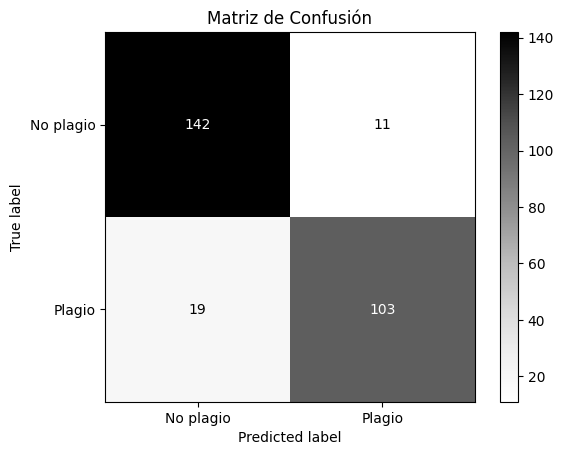

In [13]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No plagio', 'Plagio'])
disp.plot(cmap='Grays') 
plt.title('Matriz de Confusión')
plt.show()

In [14]:
model.save_model('xgboost_model.json')